In [91]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import os
import json

from firebase_admin import credentials, firestore
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()


import logging
logging.basicConfig(filename='training_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao', 'z']
ACTIVITIES = ['sit','walk','upstair']
CHUNK_SIZE = 1.375  # in seconds (can be a decimal)
SAMPLING_RATE = 100  # Hz
NUM_CLASSES = 3

In [92]:
# Data Structures
def fetch_data(collection_name, activities, include_only, time_start=500, time_end=6000):
    """Fetch and preprocess data from Firestore."""
    data, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                docs.append(record)
                df = pd.DataFrame(record['acceleration'])
                
                if 'time' in df.columns:
                    filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                    data.append(filtered_df)
                else:
                    raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

# Fetch and preprocess training/testing data
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [93]:
# Function to chunk data into smaller segments for training/testing
def chunk_data(data_raw, docs, chunk_size, activities, sampling_rate):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))
    chunk_samples = int(chunk_size * sampling_rate)  # Convert time to sample count

    for i in range(len(data_raw)):
        num_chunks = len(data_raw[i]) // chunk_samples  # Number of full chunks
        for j in range(num_chunks):
            start = j * chunk_samples
            end = start + chunk_samples
            x = list(data_raw[i]["x"])[start:end]
            y = list(data_raw[i]["y"])[start:end]
            z = list(data_raw[i]["z"])[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution

# Chunk the data
training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)
testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)

In [94]:
from tabulate import tabulate #for table formatting

#Calculate the number of training and testing samples
num_training_samples = len(training_data)
num_testing_samples = len(testing_data)

#table
summary_table = [["training", num_training_samples], ["testing", num_testing_samples]]

#print
print("dataset summary:")
print(tabulate(summary_table, headers = ["Dataset", "number of chunks"], tablefmt="pretty"))

print("Training Activities Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}: {int(training_distribution[i])} chunks")

print("\nTesting Activity Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}:{int(testing_distribution[i])} chunks")
print(len(training_data))
print(len(testing_data))
print(np.array(training_data).shape)
print(len(training_data_raw))
print(len(testing_data_raw))

dataset summary:
+----------+------------------+
| Dataset  | number of chunks |
+----------+------------------+
| training |       144        |
| testing  |       144        |
+----------+------------------+
Training Activities Count
sit: 48 chunks
walk: 48 chunks
upstair: 48 chunks

Testing Activity Count
sit:48 chunks
walk:48 chunks
upstair:48 chunks
144
144
(144, 3, 137)
36
36


In [95]:
# Convert the data to NumPy arrays
training_data = np.array(training_data)
testing_data = np.array(testing_data)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(training_data.reshape(-1, training_data.shape[-1])).reshape(training_data.shape)
X_test = scaler.transform(testing_data.reshape(-1, testing_data.shape[-1])).reshape(testing_data.shape)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(testing_labels, dtype=torch.long)

# Create TensorDataset and DataLoader for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)

In [96]:
import torch.nn.functional as F

class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_pool(x)  # Output: (batch, 64, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 64)
        return x

# Instantiate and prepare the model
cnn_extractor = CNNFeatureExtractor()
cnn_extractor.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_extractor.to(device)

# If your input is shaped incorrectly, fix it before passing to CNN
if X_train.shape[1] != 3:
    X_train = X_train.permute(0, 2, 1)

X_train_transposed = X_train.to(device)

# Same for test
if X_test.shape[1] != 3:
    X_test = X_test.permute(0, 2, 1)

X_test_transposed = X_test.to(device)

# Extract CNN features
with torch.no_grad():
    train_features = cnn_extractor(X_train_transposed).cpu().numpy()
    test_features = cnn_extractor(X_test_transposed).cpu().numpy()


In [97]:
class OptimizedCNNModel(nn.Module):
    def __init__(self, num_classes, input_channels=3, seq_length=int(CHUNK_SIZE * 100)):
        super(OptimizedCNNModel, self).__init__()

        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, padding=1):
            """Depthwise Separable Convolution for efficiency."""
            return nn.Sequential(
                nn.Conv1d(in_channels, in_channels, kernel_size, groups=in_channels, padding=padding, bias=False),
                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.GroupNorm(8, out_channels),  # More stable than BatchNorm for small batches
                nn.SiLU()  # Swish activation (better than ReLU)
            )

        self.conv1 = depthwise_separable_conv(input_channels, 8)
        self.conv2 = depthwise_separable_conv(8, 16)
        self.conv3 = depthwise_separable_conv(16, 32)

        # Adaptive pooling to ensure flexible sequence length compatibility
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.4)

        # Weight initialization
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool1d(x, 2)

        x = self.conv2(x)
        x = F.max_pool1d(x, 2)

        x = self.conv3(x)
        x = F.max_pool1d(x, 2)

        # Global Average Pooling to reduce to fixed size
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.silu(self.fc1(x))  # Swish activation
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [98]:
""" need to fix lstm cnn combo
class OptimizedCNNModel(nn.Module):
    def __init__(self, num_classes, input_channels=3, seq_length=int(CHUNK_SIZE * 100), lstm_hidden_size=64, lstm_layers=1):
        super(OptimizedCNNModel, self).__init__()

        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, padding=1):
            return nn.Sequential(
                nn.Conv1d(in_channels, in_channels, kernel_size, groups=in_channels, padding=padding, bias=False),
                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.GroupNorm(8, out_channels),
                nn.SiLU()
            )

        self.conv1 = depthwise_separable_conv(input_channels, 8)
        self.conv2 = depthwise_separable_conv(8, 16)
        self.conv3 = depthwise_separable_conv(16, 32)

        self.global_pool = nn.AdaptiveAvgPool1d(seq_length // 8)

        self.lstm = nn.LSTM(input_size=32, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)

        self.fc1 = nn.Linear(lstm_hidden_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, num_classes)

        self.dropout = nn.Dropout(0.4)
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool1d(x, 2)
        x = self.conv2(x)
        x = F.max_pool1d(x, 2)
        x = self.conv3(x)
        x = F.max_pool1d(x, 2)
        x = self.global_pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = F.silu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
"""

" need to fix lstm cnn combo\nclass OptimizedCNNModel(nn.Module):\n    def __init__(self, num_classes, input_channels=3, seq_length=int(CHUNK_SIZE * 100), lstm_hidden_size=64, lstm_layers=1):\n        super(OptimizedCNNModel, self).__init__()\n\n        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, padding=1):\n            return nn.Sequential(\n                nn.Conv1d(in_channels, in_channels, kernel_size, groups=in_channels, padding=padding, bias=False),\n                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),\n                nn.GroupNorm(8, out_channels),\n                nn.SiLU()\n            )\n\n        self.conv1 = depthwise_separable_conv(input_channels, 8)\n        self.conv2 = depthwise_separable_conv(8, 16)\n        self.conv3 = depthwise_separable_conv(16, 32)\n\n        self.global_pool = nn.AdaptiveAvgPool1d(seq_length // 8)\n\n        self.lstm = nn.LSTM(input_size=32, hidden_size=lstm_hidden_size, num_layers=lstm_lay

In [99]:
# Path to save best model and metadata
BEST_MODEL_PATH = "best_model.pth"
BEST_METADATA_PATH = "best_model.json"

# Function to save best model
def save_best_model(epoch, model, optimizer, test_loss, train_losses, test_losses):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'test_loss': test_loss,
        'train_losses': train_losses,
        'test_losses': test_losses
    }, BEST_MODEL_PATH)

    # Save metadata
    with open(BEST_METADATA_PATH, "w") as f:
        json.dump({"epoch": epoch, "test_loss": test_loss}, f)

# Function to load best model if exists
def load_best_model(model, optimizer):
    if os.path.exists(BEST_MODEL_PATH) and os.path.exists(BEST_METADATA_PATH):
        checkpoint = torch.load(BEST_MODEL_PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_loss = checkpoint['test_loss']
        train_losses = checkpoint.get('train_losses', [])
        test_losses = checkpoint.get('test_losses', [])

        print(f"Loaded best model from epoch {start_epoch} with Avg Loss: {best_loss:.4f}")
        return start_epoch, best_loss, train_losses, test_losses
    return 0, float('inf'), 0.0, [], []  # Start fresh if no saved model

In [100]:
def evaluate_model(loader, model, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # disable gradient calc
        for data, targets in loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # accuracy
            _, predicted = torch.max(outputs, 1)  # get predicted class (max value)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.interpolate import interp1d
from torch.optim import Adam

# Data Augmentation Functions
def add_jitter(batch_X, noise_level=0.01):
    noise = torch.randn_like(batch_X) * noise_level
    return batch_X + noise

def scale_signal(batch_X, scale_range=(0.9, 1.1)):
    scale_factor = torch.FloatTensor(batch_X.shape[0], 1, 1).uniform_(*scale_range)
    return batch_X * scale_factor

def time_warp(batch_X, sigma=0.2):
    batch_size, num_channels, seq_length = batch_X.shape
    time_steps = np.arange(seq_length)
    warping_curve = np.cumsum(np.random.normal(0, sigma, size=(batch_size, seq_length)), axis=1)
    warping_curve = (warping_curve - warping_curve.min(axis=1, keepdims=True)) / \
                    (warping_curve.max(axis=1, keepdims=True) - warping_curve.min(axis=1, keepdims=True)) * seq_length
    warped_X = torch.zeros_like(batch_X)
    for i in range(batch_size):
        for j in range(num_channels):
            f = interp1d(time_steps, batch_X[i, j, :].cpu().numpy(), kind='linear', fill_value='extrapolate')
            warped_X[i, j, :] = torch.tensor(f(warping_curve[i]), dtype=batch_X.dtype)
    return warped_X

def random_crop(batch_X, crop_size=0.9):
    batch_size, num_channels, seq_length = batch_X.shape
    new_length = int(seq_length * crop_size)
    start_idx = torch.randint(0, seq_length - new_length, (batch_size,))
    cropped_X = torch.zeros(batch_size, num_channels, new_length)
    for i in range(batch_size):
        cropped_X[i] = batch_X[i, :, start_idx[i]:start_idx[i] + new_length]
    return cropped_X

def permute_segments(batch_X, num_segments=5):
    batch_size, num_channels, seq_length = batch_X.shape
    segment_length = seq_length // num_segments
    permuted_X = batch_X.clone()
    for i in range(batch_size):
        perm = torch.randperm(num_segments)
        for j in range(num_segments):
            permuted_X[i, :, j * segment_length:(j + 1) * segment_length] = \
                batch_X[i, :, perm[j] * segment_length:(perm[j] + 1) * segment_length]
    return permuted_X

In [102]:
model = OptimizedCNNModel(num_classes=NUM_CLASSES, input_channels=3, seq_length=int(CHUNK_SIZE * 100))
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay helps reduce overfitting
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-4)

# Load best model if exists
start_epoch, best_loss, best_avg_accuracy, train_losses = load_best_model(model, optimizer)
#start_epoch, best_loss, best_avg_accuracy, train_losses, test_losses =  0, float('inf'), 0.0, [], []

Loaded best model from epoch 9 with Avg Loss: 0.4866


In [103]:
train_losses = []
test_losses = []

epochs = 100
for epoch in range(0, epochs):
    model.train()

    for batch_X, batch_y in train_loader:
        """if torch.rand(1).item() < 0.5:
            batch_X = add_jitter(batch_X, noise_level=0.02)
        if torch.rand(1).item() < 0.3:
            batch_X = scale_signal(batch_X, scale_range=(0.8, 1.2))
        if torch.rand(1).item() < 0.3:
            batch_X = time_warp(batch_X, sigma=0.2)
        if torch.rand(1).item() < 0.3:
            batch_X = random_crop(batch_X, crop_size=0.8)
        if torch.rand(1).item() < 0.2:
            batch_X = permute_segments(batch_X, num_segments=4)"""
            
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    train_loss, train_accuracy = evaluate_model(train_loader, model, criterion)
    test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
    current_lr = optimizer.param_groups[0]['lr']

    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    log_message = (f"Epoch [{epoch+1}/{epochs}], "
                   f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
                   f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, "
                   f"LR: {current_lr:.6f}")

    logging.info(log_message)
    print(log_message)

    if test_loss < best_loss:
        best_loss = test_loss
        save_best_model(epoch, model, optimizer, test_loss, train_losses, test_losses)
        print(f"New best model saved at epoch {epoch+1} with Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    scheduler.step(train_loss)

Epoch [1/100], Train Loss: 0.3501, Train Acc: 85.42%, Test Loss: 0.4886, Test Acc: 76.39%, LR: 0.000500
Epoch [1/100] - Train Loss: 0.3501, Train Acc: 85.42%, Test Loss: 0.4886, Test Acc: 76.39%
Epoch [2/100], Train Loss: 0.3746, Train Acc: 86.81%, Test Loss: 0.4930, Test Acc: 75.00%, LR: 0.000500
Epoch [2/100] - Train Loss: 0.3746, Train Acc: 86.81%, Test Loss: 0.4930, Test Acc: 75.00%
Epoch [3/100], Train Loss: 0.3924, Train Acc: 86.81%, Test Loss: 0.4966, Test Acc: 74.31%, LR: 0.000500
Epoch [3/100] - Train Loss: 0.3924, Train Acc: 86.81%, Test Loss: 0.4966, Test Acc: 74.31%
Epoch [4/100], Train Loss: 0.3538, Train Acc: 86.81%, Test Loss: 0.4990, Test Acc: 72.92%, LR: 0.000500
Epoch [4/100] - Train Loss: 0.3538, Train Acc: 86.81%, Test Loss: 0.4990, Test Acc: 72.92%
Epoch [5/100], Train Loss: 0.3536, Train Acc: 86.11%, Test Loss: 0.5011, Test Acc: 72.92%, LR: 0.000500
Epoch [5/100] - Train Loss: 0.3536, Train Acc: 86.11%, Test Loss: 0.5011, Test Acc: 72.92%
Epoch [6/100], Train Loss

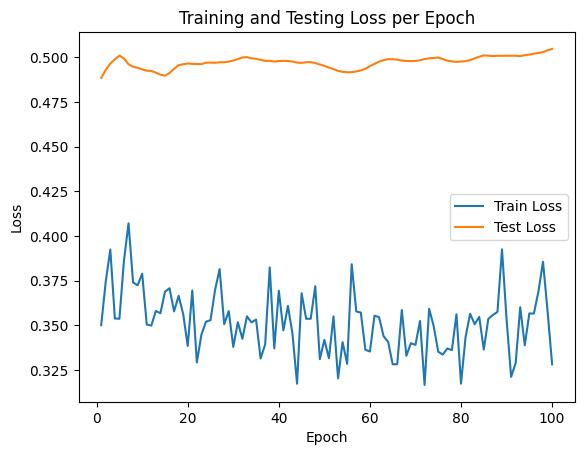

In [104]:
# Plot losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss per Epoch')
plt.legend()
plt.show()

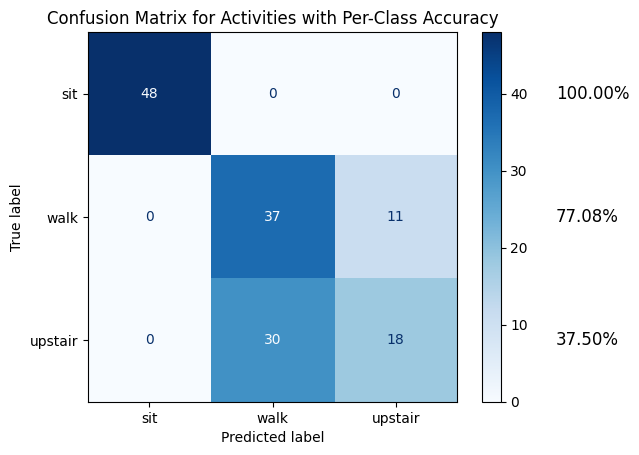

In [105]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Activities for the Confusion matrix
ACTIVITIES = ['sit', 'walk','upstair']

# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2]) 

# Assuming conf_matrix and ACTIVITIES are already defined
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Compute per-class accuracy

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Add per-class accuracy text
for i, activity in enumerate(ACTIVITIES):
    acc_text = f"{class_accuracies[i] * 100:.2f}%"
    ax.text(
        len(ACTIVITIES) + 0.3, i, acc_text, 
        fontsize=12, verticalalignment='center', color='black'
    )

plt.title("Confusion Matrix for Activities with Per-Class Accuracy")
plt.show()

In [106]:
import torch.nn.functional as F

model.eval()  # Set model to evaluation mode
incorrect_samples = []

with torch.no_grad():  # Disable gradient computation
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # Get raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
        predicted_labels = torch.argmax(probabilities, dim=1)  # Get predicted class
        confidence_scores = torch.max(probabilities, dim=1).values  # Get max confidence

        # Find incorrect predictions
        incorrect_indices = (predicted_labels != batch_y)
        for i in range(len(batch_y)):
            if incorrect_indices[i]:
                incorrect_samples.append({
                    "True Label": batch_y[i].item(),
                    "Predicted Label": predicted_labels[i].item(),
                    "Confidence": confidence_scores[i].item(),
                    "Probabilities": probabilities[i].tolist()
                })

# Print results
for sample in incorrect_samples:
    print(f"True Label: {sample['True Label']}, Predicted: {sample['Predicted Label']}, Confidence: {sample['Confidence']:.4f}")
    print(f"Full Probabilities: {sample['Probabilities']}")

True Label: 1, Predicted: 2, Confidence: 0.5605
Full Probabilities: [2.05037540581543e-05, 0.43943485617637634, 0.5604958534240723, 9.254564247385133e-06, 3.2059808745543705e-06, 4.369805992610054e-07, 1.8643811927177012e-05, 1.715189682727214e-05]
True Label: 2, Predicted: 1, Confidence: 0.5547
Full Probabilities: [0.0006324815913103521, 0.5546690821647644, 0.44453662633895874, 3.4648783184820786e-05, 1.8350518075749278e-05, 4.7813746277824976e-06, 6.643065717071295e-05, 3.754850695258938e-05]
True Label: 2, Predicted: 1, Confidence: 0.7080
Full Probabilities: [0.0007548680296167731, 0.7079601883888245, 0.29113873839378357, 3.6416884540813044e-05, 1.995328420889564e-05, 4.273280865163542e-06, 5.4933556384639814e-05, 3.061284951400012e-05]
True Label: 2, Predicted: 1, Confidence: 0.5537
Full Probabilities: [0.0017859265208244324, 0.5537185072898865, 0.44434523582458496, 3.277096038800664e-05, 1.467353376938263e-05, 4.288197942514671e-06, 6.935521378181875e-05, 2.930389928224031e-05]
Tr

In [107]:
#move up to use if need to find best chunk size
chunk_sizes = [
    0.25, 0.5, 1.0, 1.375, 2.0, 2.75, 3.0, 3.5, 4.0, 5, 5.5
]
accuracies = []

for chunk_size in chunk_sizes:
    print(f"\nTesting chunk size: {chunk_size} seconds")
    
    training_data, training_labels, _ = chunk_data(training_data_raw, training_docs, chunk_size, ACTIVITIES, SAMPLING_RATE)
    testing_data, testing_labels, _ = chunk_data(testing_data_raw, testing_docs, chunk_size, ACTIVITIES, SAMPLING_RATE)
    
    training_data = np.array(training_data)
    testing_data = np.array(testing_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(training_data.reshape(-1, training_data.shape[-1])).reshape(training_data.shape)
    X_test = scaler.transform(testing_data.reshape(-1, testing_data.shape[-1])).reshape(testing_data.shape)
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(training_labels, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(testing_labels, dtype=torch.long)
    
    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
    
    model = OptimizedCNNModel(num_classes=NUM_CLASSES, input_channels=3, seq_length=int(CHUNK_SIZE * 100))
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    epochs = 100
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
    accuracies.append(test_accuracy)
    print(f"Chunk size {chunk_size}s - Test Accuracy: {test_accuracy:.2f}%")

best_chunk_size = chunk_sizes[np.argmax(accuracies)]
print(f"\nBest Chunk Size: {best_chunk_size} with Test Accuracy: {max(accuracies):.2f}%")


Testing chunk size: 0.25 seconds
Chunk size 0.25s - Test Accuracy: 78.54%

Testing chunk size: 0.5 seconds
Chunk size 0.5s - Test Accuracy: 74.49%

Testing chunk size: 1.0 seconds
Chunk size 1.0s - Test Accuracy: 82.78%

Testing chunk size: 1.375 seconds
Chunk size 1.375s - Test Accuracy: 75.00%

Testing chunk size: 2.0 seconds
Chunk size 2.0s - Test Accuracy: 69.44%

Testing chunk size: 2.75 seconds
Chunk size 2.75s - Test Accuracy: 77.78%

Testing chunk size: 3.0 seconds
Chunk size 3.0s - Test Accuracy: 69.44%

Testing chunk size: 3.5 seconds
Chunk size 3.5s - Test Accuracy: 55.56%

Testing chunk size: 4.0 seconds
Chunk size 4.0s - Test Accuracy: 63.89%

Testing chunk size: 5 seconds
Chunk size 5s - Test Accuracy: 66.67%

Testing chunk size: 5.5 seconds
Chunk size 5.5s - Test Accuracy: 55.56%

Best Chunk Size: 1.0 with Test Accuracy: 82.78%
